In [1]:
import os
os.chdir("..")

import torch
import torch.nn as nn
import numpy as np
from torch import optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from data.dataloader import dl_from_numpy, dataloader_info
from models.predictor import GRU
from utils.utils import load_yaml_config, instantiate_from_config
from models.solver import train_prediction_model

/home/harim/Desktop/pyproject/Project_TS_Generation/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load configurations
configs = load_yaml_config("configs/stock_prediction.yaml")
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load dataset info
dl_info_train = dataloader_info(configs)
dl_info_test = dataloader_info(configs, train=False)
dataset = dl_info_train['dataset']
seq_length, feature_dim = dataset.window, dataset.feature_dim
batch_size = configs["dataloader"]["batch_size"]

# Load dataloader
ori_dl = dl_from_numpy(os.path.join(dataset.dir, f"stock_ground_truth_data_{seq_length}_train.npy"), batch_size=batch_size)
fake_dl = dl_from_numpy(os.path.join(dataset.dir, f"ddpm_fake_stock.npy"), batch_size=batch_size)
dl_test = dl_info_test["dataloader"]

# ori_fake_dl
ori_dataset = torch.from_numpy(np.load(os.path.join(dataset.dir, f"stock_ground_truth_data_{seq_length}_train.npy"))).to(device)
fake_dataset = torch.from_numpy(np.load(os.path.join(dataset.dir, f"ddpm_fake_stock.npy"))).to(device)
ori_fake_dataset = torch.concatenate([ori_dataset, fake_dataset])
ori_fake_dl = DataLoader(ori_fake_dataset, batch_size=batch_size, shuffle=True)


# Concatenate adversarial data with original data for training
ts_diffusion_adv = instantiate_from_config(configs['model']).to(device)

KeyboardInterrupt: 

In [ ]:
# models
model_ori = GRU(input_dim=feature_dim, hidden_dim=50, num_layers=2).to(device)
model_ori_fake = GRU(input_dim=feature_dim, hidden_dim=50, num_layers=2).to(device)
model_ori_adv = GRU(input_dim=feature_dim, hidden_dim=50, num_layers=2).to(device)

In [ ]:
# loss function
lossfn = nn.L1Loss()

# optimizer
lr = 0.001
optimizer_ori = optim.Adam(model_ori.parameters(), lr=lr)
optimizer_ori_fake = optim.Adam(model_ori_fake.parameters(), lr=lr)
optimizer_ori_adv = optim.Adam(model_ori_adv.parameters(), lr=lr)



In [ ]:
train_prediction_model(model_ori, ori_dl, lossfn, optimizer_ori, device=device, epochs=2000, description="Original")
train_prediction_model(model_ori_fake, ori_fake_dl, lossfn, optimizer_ori_fake, device=device, epochs=2000, description="Original + Synthetic")

Original + Synthetic loss: 0.026738: 100%|██████████| 2000/2000 [01:30<00:00, 22.07it/s]


In [ ]:
# # ori_adv_dl
# from models.diffusion import DiffusionTSAdversarial
# diffusion_adversarial = DiffusionTSAdversarial(
#     seq_length=24, n_feat=5, n_embd=128, timesteps=1000,
#     loss_type='l1', beta_sch='cosine',
#     n_heads=8, mlp_hidden_times=4,
#     n_layer_enc=1, n_layer_dec=4,
#     use_ff=True
# ).to(device)

# import torch
# Initialize the model class
from models.diffusion import DiffusionTSAdversarial
diffusion_adversarial = DiffusionTSAdversarial(
    seq_length=24, n_feat=5, n_embd=128, timesteps=500,
    loss_type='l1', beta_sch='cosine',
    n_heads=8, mlp_hidden_times=4,
    n_layer_enc=1, n_layer_dec=4,
    use_ff=True
).to(device)
# Load state dict into the model
diffusion_adversarial.load_state_dict(torch.load("check_points/model_50000.pth"))


# make adv_data on trained original model
adv_data = diffusion_adversarial.generate_adversarial(ori_dataset, predictor=model_ori,num_timesteps=10)
ori_adv_dataset = torch.cat([ori_dataset, adv_data])
ori_adv_dl = DataLoader(ori_adv_dataset, batch_size=128, shuffle=True)

/home/harim/Desktop/pyproject/Project_TS_Generation/.venv/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
/home/harim/Desktop/pyproject/Project_TS_Generation/.venv/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


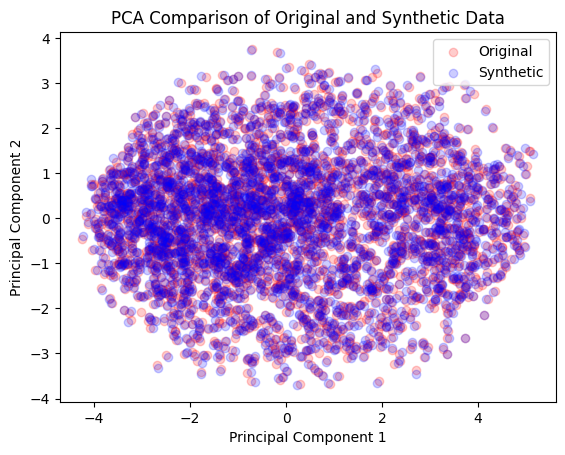

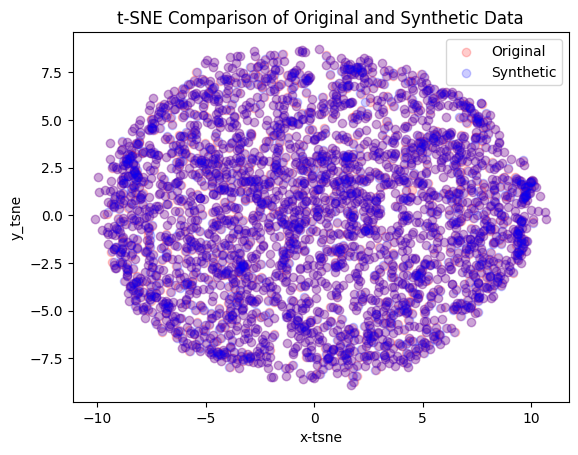

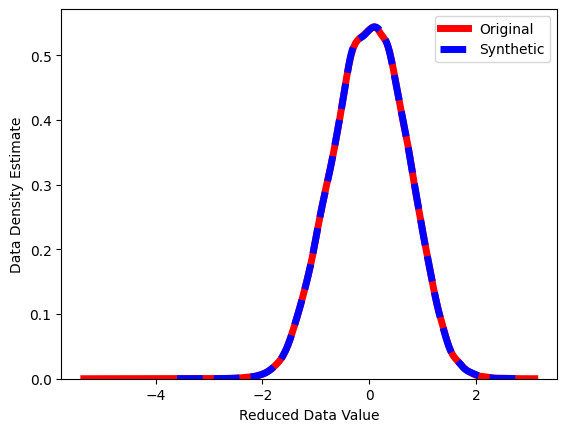

In [ ]:
from utils.visualize import visualize_pca, visualize_tsne, visualize_kernel
visualize_pca(ori_data=ori_dataset.detach().cpu(), fake_data=adv_data.detach().cpu())
visualize_tsne(ori_data=ori_dataset.detach().cpu(), fake_data=adv_data.detach().cpu())
visualize_kernel(ori_data=ori_dataset.detach().cpu(), fake_data=adv_data.detach().cpu())

In [ ]:
# Train on original data
train_prediction_model(model_ori_adv, ori_adv_dl, lossfn, optimizer_ori_adv, device=device, epochs=2000, description="Original + Adv")

Original + Adv loss: 0.026678: 100%|██████████| 2000/2000 [01:31<00:00, 21.81it/s]


In [ ]:
test_data_norm = torch.from_numpy(np.load(os.path.join(dataset.dir, f"stock_ground_truth_data_{seq_length}_test.npy"))).to(device)
test_mean = torch.from_numpy(np.load(os.path.join(dataset.dir, f"stock_ground_truth_mean_{seq_length}_test.npy"))).to(device)
test_std = torch.from_numpy(np.load(os.path.join(dataset.dir, f"stock_ground_truth_std_{seq_length}_test.npy"))).to(device)

from torch.utils.data import DataLoader, TensorDataset
test_dataset = TensorDataset(test_data_norm, test_mean, test_std)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
model = model_ori
dataloader = test_loader
model.eval()
criterion = nn.L1Loss()
mapeloss = MeanAbsolutePercentageError().to(device)
total_loss = 0
predictions, true_vals = [], []
with torch.no_grad():
    for data, mean, std in dataloader:
        x_test = data[:, :(seq_length - 1), :].float().to(device)
        y_test = data[:, (seq_length - 1) :, :1].float().to(device)
        mean = mean[:, :, :1].float().to(device)
        std = std[:, :, :1].float().to(device)
        y_pred = model(x_test).view(-1,1,1)
        
        total_loss += criterion(y_pred, y_test) * len(data)

        y_test_unnorm = y_test * std + mean
        y_pred_unnorm = y_pred * std + mean

        predictions.append(y_pred_unnorm.cpu().numpy())
        true_vals.append(y_test_unnorm.cpu().numpy())

total_loss /= len(dataloader.dataset)
predictions = np.concatenate(predictions)
true_vals = np.concatenate(true_vals)
mape_loss = mapeloss(torch.tensor(predictions), torch.tensor(true_vals)).item()

In [ ]:
# Evaluate models on the test dataset
def evaluate_model(model, dataloader):
    model.eval()
    criterion = nn.L1Loss()
    criterion2 = nn.MSELoss()
    mapeloss = MeanAbsolutePercentageError().to(device)
    total_loss_L1 = 0
    total_loss_MSE = 0
    predictions, true_vals = [], []
    with torch.no_grad():
        for data, mean, std in dataloader:
            x_test = data[:, :(seq_length - 1), :].float().to(device)
            y_test = data[:, (seq_length - 1) :, :1].float().to(device)
            mean = mean[:, :, :1].float().to(device)
            std = std[:, :, :1].float().to(device)
            y_pred = model(x_test).view(-1,1,1)
            
            total_loss_L1 += criterion(y_pred, y_test) * len(data)
            total_loss_MSE += criterion2(y_pred, y_test) * len(data)

            y_test_unnorm = y_test * std + mean
            y_pred_unnorm = y_pred * std + mean

            predictions.append(y_pred_unnorm.cpu().numpy())
            true_vals.append(y_test_unnorm.cpu().numpy())

    total_loss_L1 /= len(dataloader.dataset)
    total_loss_MSE /= len(dataloader.dataset)
    predictions = np.concatenate(predictions).squeeze()
    true_vals = np.concatenate(true_vals).squeeze()
    mape_loss = mapeloss(torch.tensor(predictions), torch.tensor(true_vals)).item()
    
    return total_loss_L1, total_loss_MSE, mape_loss, predictions, true_vals

In [ ]:
ori_l1, ori_l2, mape_ori, pred_y_ori, true_y = evaluate_model(model_ori, test_loader)
ori_fake_l1, ori_fake_l2, mape_ori_fake, pred_y_ori_fake, _ = evaluate_model(model_ori_fake, test_loader)
ori_adv_l1, ori_adv_l2, mape_ori_adv, pred_y_ori_adv, _ = evaluate_model(model_ori_adv, test_loader)

print(f"Original Model : \t L1 loss: {ori_l1:0.5f} \t L2 Loss : {ori_l2:0.5f} \t MAPE loss : {mape_ori:0.5f} ")
print(f"Original + Fake Model : \t L1 loss: {ori_fake_l1:0.5f} \t L2 Loss : {ori_fake_l2:0.5f} \t MAPE loss : {mape_ori_fake:0.5f} ")
print(f"Original + Adv Model : \t L1 loss: {ori_adv_l1:0.5f} \t L2 Loss : {ori_adv_l2:0.5f} \t MAPE loss : {mape_ori_adv:0.5f} ")


Original Model : 	 L1 loss: 0.62497 	 L2 Loss : 0.74383 	 MAPE loss : 0.01749 
Original + Fake Model : 	 L1 loss: 0.62702 	 L2 Loss : 0.73185 	 MAPE loss : 0.01735 
Original + Adv Model : 	 L1 loss: 0.62085 	 L2 Loss : 0.72955 	 MAPE loss : 0.01744 


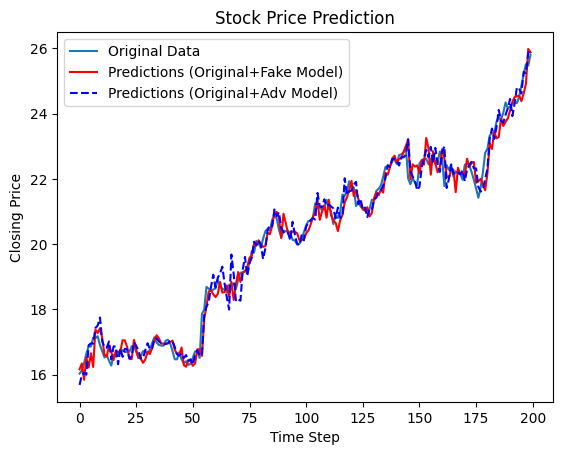

In [ ]:
# Visualize predictions
plt.figure()
plt.plot(true_y[:200], label='Original Data')
plt.plot(pred_y_ori_fake[:200], label='Predictions (Original+Fake Model)', linestyle='-', color='r')
plt.plot(pred_y_ori_adv[:200], label='Predictions (Original+Adv Model)', linestyle='--', color='b')
plt.legend()
plt.title("Stock Price Prediction")
plt.xlabel("Time Step")
plt.ylabel("Closing Price")
plt.show()


In [ ]:
# quantatitive metrics
# cross correlation score

from metrics.cross_correlation import CrossCorrelLoss
from utils.utils import display_scores

iterations = 5
def random_choice(size, num_select=100):
    select_idx = np.random.randint(low=0, high=size, size=(num_select,))
    return select_idx

x_real = ori_dataset.detach().cpu()
# x_fake = ori_dataset.detach().cpu()
x_fake = adv_data.detach().cpu()

correlational_score = []
size = int(x_real.shape[0] / iterations)

for i in range(iterations):
    real_idx = random_choice(x_real.shape[0], size)
    fake_idx = random_choice(x_fake.shape[0], size)
    corr = CrossCorrelLoss(x_real[real_idx, :, :], name='CrossCorrelLoss')
    loss = corr.compute(x_fake[fake_idx, :, :])
    correlational_score.append(loss.item())
    print(f'Iter {i}: ', 'cross-correlation =', loss.item(), '\n')

display_scores(correlational_score)

Iter 0:  cross-correlation = 0.024827441200613976 

Iter 1:  cross-correlation = 0.019541403278708458 

Iter 2:  cross-correlation = 0.015108807012438774 

Iter 3:  cross-correlation = 0.020720286294817924 

Iter 4:  cross-correlation = 0.024611197412014008 

Final Score: 0.02096 ± 0.00499


In [ ]:
for _ in range(30):
    adv_data = diffusion_adversarial.generate_adversarial(ori_dataset, predictor=model_ori,num_timesteps=10)
    ori_adv_dl = DataLoader(adv_data, batch_size=128, shuffle=True)
    train_prediction_model(model_ori_adv, ori_adv_dl, lossfn, optimizer_ori_adv, device=device, epochs=500, description="Original + Adv")
    ori_adv_l1, ori_adv_l2, mape_ori_adv, pred_y_ori_adv, _ = evaluate_model(model_ori_adv, test_loader)
    print(f"Original + Adv Model : \t L1 loss: {ori_adv_l1:0.5f} \t L2 Loss : {ori_adv_l2:0.5f} \t MAPE loss : {mape_ori_adv:0.5f} ")


Original + Adv loss: 0.025342: 100%|██████████| 500/500 [00:11<00:00, 42.06it/s]


Original + Adv Model : 	 L1 loss: 0.61173 	 L2 Loss : 0.70854 	 MAPE loss : 0.01712 


Original + Adv loss: 0.016617: 100%|██████████| 500/500 [00:11<00:00, 41.73it/s]


Original + Adv Model : 	 L1 loss: 0.61088 	 L2 Loss : 0.70354 	 MAPE loss : 0.01720 


Original + Adv loss: 0.023622: 100%|██████████| 500/500 [00:11<00:00, 42.29it/s]


Original + Adv Model : 	 L1 loss: 0.60512 	 L2 Loss : 0.69358 	 MAPE loss : 0.01702 


Original + Adv loss: 0.019048: 100%|██████████| 500/500 [00:11<00:00, 42.32it/s]


Original + Adv Model : 	 L1 loss: 0.59773 	 L2 Loss : 0.68699 	 MAPE loss : 0.01674 


Original + Adv loss: 0.022362: 100%|██████████| 500/500 [00:11<00:00, 42.40it/s]


Original + Adv Model : 	 L1 loss: 0.59957 	 L2 Loss : 0.69001 	 MAPE loss : 0.01675 


Original + Adv loss: 0.020400: 100%|██████████| 500/500 [00:12<00:00, 41.56it/s]


Original + Adv Model : 	 L1 loss: 0.59414 	 L2 Loss : 0.68153 	 MAPE loss : 0.01671 


Original + Adv loss: 0.022462: 100%|██████████| 500/500 [00:11<00:00, 41.90it/s]


Original + Adv Model : 	 L1 loss: 0.59454 	 L2 Loss : 0.68080 	 MAPE loss : 0.01661 


Original + Adv loss: 0.019469: 100%|██████████| 500/500 [00:11<00:00, 42.06it/s]


Original + Adv Model : 	 L1 loss: 0.59078 	 L2 Loss : 0.67439 	 MAPE loss : 0.01648 


Original + Adv loss: 0.021741: 100%|██████████| 500/500 [00:11<00:00, 42.40it/s]


Original + Adv Model : 	 L1 loss: 0.59594 	 L2 Loss : 0.67936 	 MAPE loss : 0.01671 


Original + Adv loss: 0.016516: 100%|██████████| 500/500 [00:11<00:00, 42.20it/s]


Original + Adv Model : 	 L1 loss: 0.59206 	 L2 Loss : 0.67469 	 MAPE loss : 0.01658 


Original + Adv loss: 0.021699: 100%|██████████| 500/500 [00:11<00:00, 42.35it/s]


Original + Adv Model : 	 L1 loss: 0.59305 	 L2 Loss : 0.67561 	 MAPE loss : 0.01659 


Original + Adv loss: 0.015877: 100%|██████████| 500/500 [00:11<00:00, 41.77it/s]


Original + Adv Model : 	 L1 loss: 0.59812 	 L2 Loss : 0.68225 	 MAPE loss : 0.01678 


Original + Adv loss: 0.013779: 100%|██████████| 500/500 [00:11<00:00, 41.76it/s]


Original + Adv Model : 	 L1 loss: 0.58976 	 L2 Loss : 0.67346 	 MAPE loss : 0.01651 


Original + Adv loss: 0.015202: 100%|██████████| 500/500 [00:11<00:00, 42.25it/s]


Original + Adv Model : 	 L1 loss: 0.59377 	 L2 Loss : 0.67731 	 MAPE loss : 0.01668 


Original + Adv loss: 0.015993: 100%|██████████| 500/500 [00:11<00:00, 42.40it/s]


Original + Adv Model : 	 L1 loss: 0.59216 	 L2 Loss : 0.67799 	 MAPE loss : 0.01659 


KeyboardInterrupt: 